In [1]:
from data import preparation
import data.hierarchy as hie
from sklearn.model_selection import train_test_split

In [2]:
data_name = "wipo_c"

In [3]:
with open('data/%s/hierarchy.txt' % data_name, 'w') as f1:
    with open('data/%s/%s.ht' % (data_name,data_name)) as f:
        for l in f:
            split = l.strip().split(':')
            p = split[0]
            c = split[1].split(',')
            for cc in c:
                f1.write('%s %s\n'% (p,cc))

In [4]:
hierarchy, parent_of, all_name, name_to_index, level = hie.reindex_hierarchy(
                '%s/hierarchy.txt' % data_name)
hie.save_hierarchy("%s/hierarchy.pickle" % data_name, hierarchy,
                   parent_of, all_name, name_to_index, level)

In [5]:
for mode in ['train', 'test']:
    for i in range(1,6):
        datas, labels = preparation.import_data('%s/folds/%s_fold%d.dat.%s' % (data_name, data_name, i, mode))
        new_labels = preparation.map_index_of_label('%s/hierarchy.pickle' % data_name, labels)
        if mode == 'train':
            train_data, validate_data, train_target, validate_target = train_test_split(
                datas, new_labels, test_size=0.1, random_state=12345)
            preparation.save_data_in_pickle('%s/fold/data_%d.pickle.%s' % (data_name, i, mode), train_data, train_target)
            preparation.save_data_in_pickle('%s/fold/data_%d.pickle.%s' % (data_name, i, "validate"), validate_data, validate_target)
        else:
            preparation.save_data_in_pickle('%s/fold/data_%d.pickle.%s' % (data_name, i, mode), datas, new_labels)

# Real Flow 

In [6]:
from data import Dataset
from embedding import Doc2Vec
from assemble_classifier import AssembleNoLabel, AssemblePredicted,AssemblePredictedHidden
import shutil
import os

%load_ext autoreload
%autoreload 2

In [7]:
fold = 3

In [8]:
dataset_train = Dataset(data_name, fold, "train")

In [9]:
doc2vec = Doc2Vec(dataset_train.number_of_classes(), size=150, epoch=20)

Doc2Vec by Gensim


In [10]:
f1_array = []
f1_test = []
same = []
diff = []
avg_diff = []
top_k = []
top_k_similar = []

In [ ]:
%%time
for i in range(25):
    dataset_train = Dataset(data_name, fold, "train")
    dataset_validate = Dataset(data_name, fold, "validate")
    dataset_test = Dataset(data_name, fold, "test")
    s, d, a, t, ts = doc2vec.fit(dataset_train.datas, dataset_train.labels, dataset_validate.datas, dataset_validate.labels, early_stopping=False, second_run=i!=0, one_time=True)
    same.append(s)
    diff.append(d)
    avg_diff.append(a)
    top_k.append(t)
    top_k_similar.append(ts)
    # doc2vec.load_model("best_now/doc2vec.model")

    dataset_train.change_to_Doc2Vec(doc2vec)
    dataset_validate.change_to_Doc2Vec(doc2vec)
    dataset_test.change_to_Doc2Vec(doc2vec)
    
    if os.path.isdir('data/%s/output' % data_name):
        shutil.rmtree('data/%s/output' % data_name)

    model =  AssemblePredicted(data_name, dataset_train, dataset_validate, dataset_test, iteration=2000, stopping_time=200, batch_size=65536, hidden_size=[300,1500,1500,1500], target_hidden_size=[60,60,60], use_dropout=True, start_level=0)
    # model = AssembleNoLabel(data_name, dataset_train, dataset_validate, dataset_test, iteration=2000, batch_size=100, hidden_size=[300,1500,1500,1500], use_dropout=False, start_level=0, end_level=100)

#     model = AssemblePredictedHidden(data_name, dataset_train, dataset_validate, dataset_test, iteration=2000, stopping_time=200, batch_size=2000, hidden_size=[300,1500,2000,2500], use_dropout=True, start_level=0, end_level=100)
    model.train(verbose=False)
    model.tuning_threshold()

    f1_macro, f1_micro, f1_each = model.evaluate("validate", correction=True)
    f1_array.append(f1_macro)
    print("Validate F1 macro: %.4f F1 micro: %.4f" % (f1_macro, f1_micro))    
    
    f1_macro, f1_micro, f1_each = model.evaluate("test", correction=True)
    f1_test.append(f1_macro)
    print("Test F1 macro: %.4f F1 micro: %.4f" % (f1_macro, f1_micro))
    print()

0.1
Epoch: 20 Similar: 0.17564
Validate F1 macro: 0.0217 F1 micro: 0.3287
Test F1 macro: 0.0278 F1 micro: 0.3307

0.1
Epoch: 20 Similar: 0.11916
Validate F1 macro: 0.0252 F1 micro: 0.3466
Test F1 macro: 0.0335 F1 micro: 0.3489

0.1
Epoch: 20 Similar: 0.08975
Validate F1 macro: 0.0265 F1 micro: 0.3787
Test F1 macro: 0.0366 F1 micro: 0.3889

0.1
Epoch: 20 Similar: 0.08229
Validate F1 macro: 0.0268 F1 micro: 0.4073
Test F1 macro: 0.0368 F1 micro: 0.4092

0.1
Epoch: 20 Similar: 0.07228
Validate F1 macro: 0.0282 F1 micro: 0.3918
Test F1 macro: 0.0410 F1 micro: 0.4031

0.1
Epoch: 20 Similar: 0.06842
Validate F1 macro: 0.0281 F1 micro: 0.4058
Test F1 macro: 0.0401 F1 micro: 0.4190

0.1
Epoch: 20 Similar: 0.07022
Validate F1 macro: 0.0282 F1 micro: 0.3838
Test F1 macro: 0.0402 F1 micro: 0.3923

0.1
Epoch: 20 Similar: 0.06762
Validate F1 macro: 0.0284 F1 micro: 0.4084
Test F1 macro: 0.0388 F1 micro: 0.4092

0.1
Epoch: 20 Similar: 0.06973
Validate F1 macro: 0.0292 F1 micro: 0.3906
Test F1 macro:

In [21]:
import numpy as np
import matplotlib.pyplot as plt


def two_scales(ax1, time, data1, data2, c1, c2):
    ax2 = ax1.twinx()

    ax1.plot(time, data1, color=c1)
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('f1 macro')

    ax2.plot(time, data2, color=c2)
    ax2.set_ylabel('metric')
    return ax1, ax2

# Change color of each axis
def color_y_axis(ax, color):
    """Color your axes."""
    for t in ax.get_yticklabels():
        t.set_color(color)
    return None

# Create some mock data
t = np.arange(120, 520, 20)
def draw_graph(s1, s2):
    s1 = np.array(s1[5:])
    s2 = np.array(s2[5:])
    
    # Create axes
    fig, ax = plt.subplots()
    ax1, ax2 = two_scales(ax, t, s1, s2, 'r', 'b')

    color_y_axis(ax1, 'r')
    color_y_axis(ax2, 'b')
    plt.show()

In [22]:
def max_ind(arr):
    arr = arr[5:25]
    ind = arr.index(max(arr)) + 5
    print(ind, f1_test[ind], f1_array[ind])

In [23]:
print(max(f1_test), max(f1_array))
max_ind(same)
max_ind(diff)
max_ind(avg_diff)
max_ind(top_k)
max_ind(top_k_similar)

0.04217389225959778 0.029172712936997414
5 0.040114451199769974 0.028060520067811012
24 0.037232983857393265 0.025314686819911003
24 0.037232983857393265 0.025314686819911003
5 0.040114451199769974 0.028060520067811012
23 0.03831445798277855 0.02610958367586136


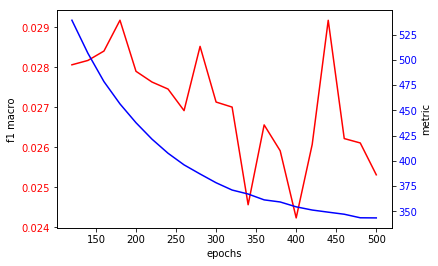

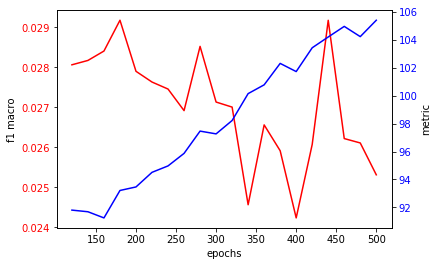

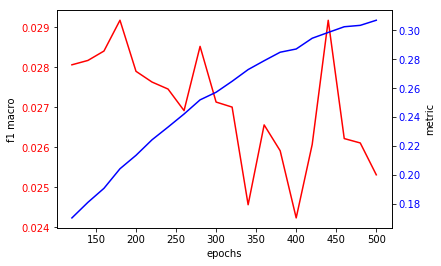

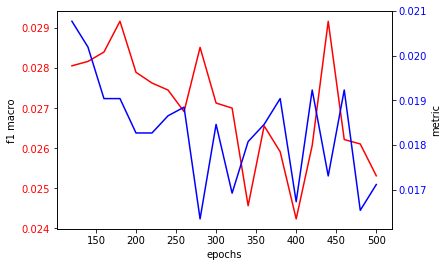

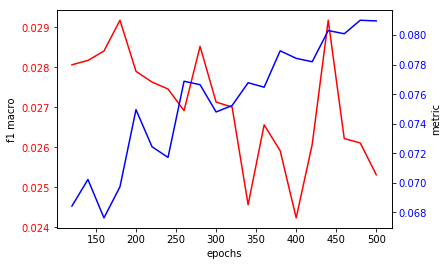

In [24]:
draw_graph(f1_array, same)
draw_graph(f1_array, diff)
draw_graph(f1_array, avg_diff)
draw_graph(f1_array, top_k)
draw_graph(f1_array, top_k_similar)

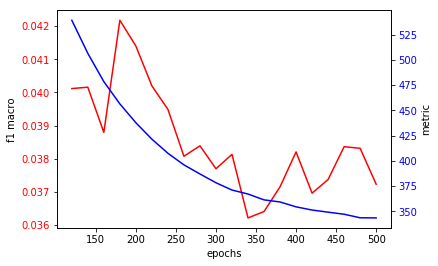

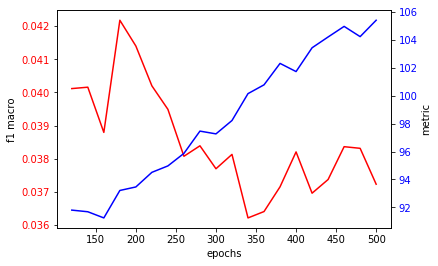

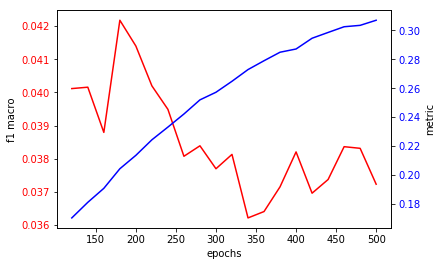

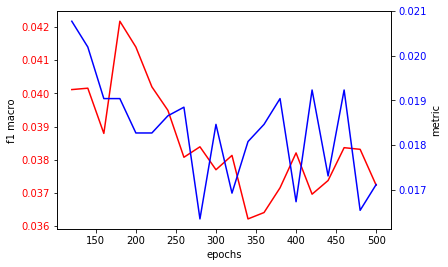

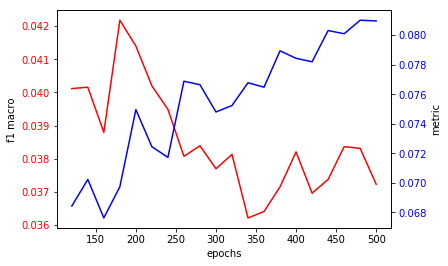

In [25]:
draw_graph(f1_test, same)
draw_graph(f1_test, diff)
draw_graph(f1_test, avg_diff)
draw_graph(f1_test, top_k)
draw_graph(f1_test, top_k_similar)